# Library and Configuration

In [136]:
# --- System & Environment Configuration --- 
import os
import random
from warnings import filterwarnings

# Matikan log TensorFlow yang tidak perlu (Set sebelum import TF)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Abaikan warnings
filterwarnings("ignore")


# --- Core Library ---
import chardet
import numpy as np
import pandas as pd
from pathlib import Path


# --- Visualization ---
import seaborn as sns
import matplotlib.pyplot as plt


# --- Scikit Learn ---
# Model Selection & Evaluation
from sklearn.model_selection import (
    KFold, 
    cross_validate, 
    cross_val_score, 
    train_test_split
)
from sklearn.metrics import (
    r2_score, 
    mean_squared_error,
    mean_absolute_error,
)
from sklearn.base import (
    BaseEstimator,
    TransformerMixin
)
    
# Preprocessing & Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    RobustScaler
)

# ML Models
import optuna
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Possible Deep Learning Frameworks
import tensorflow as tf

ROOT_PATH = Path('/kaggle/input/preliminary-round-dac-prs-2024/dataset/')
TRAIN_PATH = ROOT_PATH/'train.csv'
WEATHER_PATH = ROOT_PATH/'Weather.csv'
TEST_PATH = ROOT_PATH/'test.csv'
METADATA_PATH = ROOT_PATH/'metadata.csv'
SAMPLE_SUBMISSION = ROOT_PATH/'sample_submission.csv'
SOLAR_IRRADIANCE = ROOT_PATH/'solar-irradiance'

TARGET = '% Baseline'

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

SEED = 42
set_seed(SEED)

print('library and configuration ready!')

library and configuration ready!


In [157]:
# read data to detect encoding
with open(METADATA_PATH, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))

print(f"Detected encoding: {result['encoding']}")

# read with detected encoding
metadata = pd.read_csv(METADATA_PATH, encoding=result['encoding'], sep=';', index_col='No.')

Detected encoding: Windows-1252


# Utility Functions

In [5]:
# To make single time format for merging
def make_timestamp(df) -> pd.Series:  
    if "date_time" not in df.columns:
        raise KeyError("Column 'date_time' not found in dataframe.")
        
    dt = pd.to_datetime(df["date_time"])
    time = dt.dt.strftime("%b %-d, %Y %-I")
    suffix = dt.dt.strftime("%p").str.lower()
    
    timestamp = time + suffix
    
    return pd.to_datetime(timestamp)

# To convert multiple columns in dataframe to single datetime
def columns_to_datetime(df) -> pd.Series:
    return pd.to_datetime(
        df[['Year', 'Month', 'Day', 'Hour', 'Minute']]
    )

# To merge main dataset to multiple feature datasets
def merge_with_features(df, *feature_dfs) -> pd.DataFrame:
    if "Timestamp" not in df.columns:
        raise KeyError("Column 'Timestamp' not found in dataframe.")

    df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="mixed")
        
    for feature in feature_dfs:
        df = df.merge(feature, on="Timestamp", how="left")
        
    return df

# To load multiple csv file by year
def load_yearly_csv(path, prefix, years) -> pd.DataFrame:
    return pd.concat(
        [pd.read_csv(path / f"{prefix}_{year}.csv") for year in years],
        ignore_index=True
    )

# To convert date time format to submission format
def convert_to_submission(df) -> pd.DataFrame:
    if "Timestamp" not in df.columns:
        raise KeyError("Column 'Timestamp' not found in dataframe.")
        
    dt = pd.to_datetime(df["Timestamp"])
    time = dt.dt.strftime("%b %-d, %Y %-I")
    suffix = dt.dt.strftime("%p").str.lower()

    df['Timestamp'] = time + suffix
    return df

# To plot target
def check_transformations(series, bins=50):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    # --- Original Data ---
    sns.histplot(series, bins=bins, kde=True, ax=axes[0], color='skyblue', edgecolor='black')
    axes[0].set_title(f'Original\n(Skew: {series.skew():.2f})', fontsize=14)
    
    # --- Log Transformation ---
    series_log = np.log(series[series > 0]) 
    sns.histplot(series_log, bins=bins, kde=True, ax=axes[1], color='salmon', edgecolor='black')
    axes[1].set_title(f'Log Transform\n(Skew: {series_log.skew():.2f})', fontsize=14)
    
    # --- Square Root Transformation ---
    series_sqrt = np.sqrt(series)
    sns.histplot(series_sqrt, bins=bins, kde=True, ax=axes[2], color='lightgreen', edgecolor='black')
    axes[2].set_title(f'Square Root Transform\n(Skew: {series_sqrt.skew():.2f})', fontsize=14)

    plt.suptitle(f'{TARGET} Distribution', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

# To plot correlation coefficient for each feature with each others
def plot_numerical_correlation(X: pd.DataFrame, numerical_features: list) -> None:
    """
    Computes and visualizes the Pearson correlation matrix for numerical features
    using a heatmap.

    Args:
        X (pd.DataFrame): Input dataframe.
        numerical_features (list): List of numerical column names to correlate.
    """
    # Calculate the pairwise correlation of columns, excluding NA/null values
    correlation_matrix = X[numerical_features].corr(method='pearson')
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(
        correlation_matrix,
        cmap='coolwarm',      # Diverging colormap (Red for pos, Blue for neg)
        vmin=-1, vmax=1,      # Anchor the colormap range
        center=0,             # Center the colormap at 0
        linewidths=.5,        
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    
    plt.title('Numerical Features Correlation Heatmap (Pearson)', 
              fontsize=14, fontweight='bold')
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

def compare_similar_features(df, cols):
    """
    Membandingkan dua fitur dengan Boxplot berdampingan dan menghitung korelasi.
    Args:
        df (pd.DataFrame): Dataframe sumber.
        cols (list): List berisi dua nama kolom, e.g. ['tempC', 'Temperature']
    """
    # Validasi input biar gak error
    if len(cols) != 2:
        print("Error: List must be consist of two columns.")
        return
    
    col1, col2 = cols[0], cols[1]
    
    # Pearson Correlation
    corr_val = df[col1].corr(df[col2])

    # Plot Setup (1 Row, 2 Columns)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: First Boxplot
    sns.boxplot(y=df[col1], ax=axes[0], color='skyblue', width=0.4)
    axes[0].set_title(f'Distribusi: {col1}', fontsize=12, fontweight='bold')
    axes[0].grid(True, axis='y', alpha=0.3)

    # Plot 2: Second Boxplot
    sns.boxplot(y=df[col2], ax=axes[1], color='salmon', width=0.4)
    axes[1].set_title(f'Distribusi: {col2}', fontsize=12, fontweight='bold')
    axes[1].grid(True, axis='y', alpha=0.3)

    # Main title and correlation score
    plt.suptitle(f'Perbandingan Fitur: {col1} vs {col2}\nCorrelation Score: {corr_val:.4f}', 
                 fontsize=16, y=1.05)
    
    plt.tight_layout()
    plt.show()

# To add year, month, and day to solar and lunar features
def merge_column_with_timestamp(df, column) -> pd.Series:
    date_str = df['Timestamp'].dt.strftime('%Y-%m-%d')
    combined_str = date_str + ' ' + df[column]

    return pd.to_datetime(combined_str, errors='coerce')

# Data Loading

## Solar Irradiance features

In [6]:
# Load 4 year solar irradiance datasets
solar_irradiance = load_yearly_csv(SOLAR_IRRADIANCE, 'Solar_Irradiance', range(2014, 2018))

# Make timestamp from 5 columns in solar_irradiance: ['Year', 'Month', 'Day', 'Hour', 'Minute']
solar_irradiance['date_time'] = columns_to_datetime(solar_irradiance)
solar_irradiance['Timestamp'] = make_timestamp(solar_irradiance)

# Drop unnecessary columns
solar_irradiance.drop(columns = ['date_time', 'Year', 'Month',
                                 'Day', 'Hour', 'Minute'], inplace=True)

solar_irradiance.head()

,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Solar Zenith Angle,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure,Timestamp
0,0.0,0.0,0.0,0.0,0.0,0.0,Probably Clear,-6,124.02,0.12,3.5,78.43,-3,1010,2014-01-01 00:00:00
1,0.0,0.0,0.0,0.0,0.0,0.0,Probably Clear,-5,135.09,0.12,3.8,81.74,-3,1010,2014-01-01 01:00:00
2,0.0,0.0,0.0,0.0,0.0,0.0,Probably Clear,-5,145.77,0.12,4.2,81.25,-3,1010,2014-01-01 02:00:00
3,0.0,0.0,0.0,0.0,0.0,0.0,Probably Clear,-6,155.07,0.12,4.5,74.14,-3,1010,2014-01-01 03:00:00
4,0.0,0.0,0.0,0.0,0.0,0.0,Probably Clear,-8,160.55,0.12,4.6,72.80,-4,1010,2014-01-01 04:00:00


In [155]:
solar_metadata = metadata[metadata['Variable Name'].isin(solar_irradiance.columns)].reset_index(drop=True)
solar_metadata

,Variable Name,Description
0,Timestamp,Data collection time on solar energy plants.
1,DHI,Diffuse Horizontal Irradiance (DHI) is the quantity of solar radiation received per unit area by a horizontal surface from all directions except the sun which has been scattered by molecules and particles in the atmosphere. (Watt per square metre)
2,DNI,Direct Normal Irradiance (DNI) is the quantity of solar radiation received per unit area by a surface maintained perpendicular to the rays that come in a straight line from the Sun's current position in the sky. (Watt per square metre)
3,GHI,Global Horizontal Irradiance (GHI) is the total amount of solar radiation received per unit area by a horizontal surface. This value includes direct and diffused sunlight. (Watt per square metre)
4,Clearsky DHI,DHI radiation under clear sky conditions. (Watt per square metre)
5,Clearsky DNI,DNI radiation under clear sky conditions. (Watt per square metre)
6,Clearsky GHI,GHI radiation under clear sky conditions. (Watt per square metre)
7,Cloud Type,"Classification of cloud types at the time of measurement: Clear, Probably Clear, Fog, Water, Super-Cooled Water, Mixed, Opaque Ice, Cirrus, Overlapping, Overshooting, Unknown, Dust, Smoke"
8,Dew Point,The temperature at which the air becomes saturated with moisture and water vapor begins to condense. (Celcius)
9,Solar Zenith Angle,The angle between the sun’s rays and the vertical direction other than the solar elevation angle. (Degree)


## Weather features

In [160]:
# Load and make timestamp column for weather datasets
weather = pd.read_csv(WEATHER_PATH)
weather['Timestamp'] = make_timestamp(weather)

# Drop unnecessary column
weather.drop(columns='date_time', inplace=True)

# Merge timestamp for solar and lunar features
solar_lunar = ['sunrise', 'sunset', 'moonrise', 'moonset']

for feature in solar_lunar:
    weather[feature] = merge_column_with_timestamp(weather, feature)

weather.head()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,Timestamp
0,-3,-6,0.0,8.7,2,1,2014-01-01 06:58:00,2014-01-01 17:05:00,2014-01-01 07:12:00,2014-01-01 16:22:00,...,28,3,58,0.0,1022,-4,10,273,20,2014-01-01 00:00:00
1,-3,-6,0.0,8.7,2,1,2014-01-01 06:58:00,2014-01-01 17:05:00,2014-01-01 07:12:00,2014-01-01 16:22:00,...,31,4,58,0.0,1023,-5,10,274,22,2014-01-01 01:00:00
2,-3,-6,0.0,8.7,2,1,2014-01-01 06:58:00,2014-01-01 17:05:00,2014-01-01 07:12:00,2014-01-01 16:22:00,...,34,5,58,0.0,1024,-5,10,276,25,2014-01-01 02:00:00
3,-3,-6,0.0,8.7,2,1,2014-01-01 06:58:00,2014-01-01 17:05:00,2014-01-01 07:12:00,2014-01-01 16:22:00,...,36,6,58,0.0,1024,-5,10,278,27,2014-01-01 03:00:00
4,-3,-6,0.0,8.7,2,1,2014-01-01 06:58:00,2014-01-01 17:05:00,2014-01-01 07:12:00,2014-01-01 16:22:00,...,32,9,57,0.0,1025,-6,10,271,23,2014-01-01 04:00:00


In [161]:
weather_metadata = metadata[metadata['Variable Name'].isin(weather.columns)].reset_index(drop=True)
weather_metadata

,Variable Name,Description
0,Timestamp,Data collection time on solar energy plants.
1,maxtempC,Maximum temperature point of a region during a specific period. (Celsius)
2,mintempC,Minimum temperature point of a region during a specific period. (Celsius)
3,totalSnow_cm,Total accumulated snow height. (Centimetres)
4,sunHour,Estimated total hours of sunlight.
5,uvIndex,UV light index generated by the sun.
6,moon_illumination,Moon illumination percentage (percentage of the moon's surface exposed to sunlight).
7,moonrise,Moonrise time.
8,moonset,Moonset time.
9,sunrise,Sunrise time.


## Train and Test Merging

In [89]:
# Load the train and test dataset
test  = pd.read_csv(TEST_PATH)
train = pd.read_csv(TRAIN_PATH)

# Define feature datasets
features = (weather, solar_irradiance)

# Merge main dataset with features
train_df = merge_with_features(train, *features)
test_df = merge_with_features(test, *features)

# Print train and test shape
print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape) 

Train shape: (18942, 39)
Test shape: (1077, 39)


In [163]:
train_metadata = metadata[metadata['Variable Name'].isin(train.columns)].reset_index(drop=True)
train_metadata

,Variable Name,Description
0,Timestamp,Data collection time on solar energy plants.
1,% Baseline,Percentage of energy generated in one hour based on the energy storage capacity.


In [90]:
train_df.info()
test_df.info() # Target feature: [% Baseline]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18942 entries, 0 to 18941
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Timestamp           18942 non-null  datetime64[ns]
 1   % Baseline          18942 non-null  float64       
 2   maxtempC            18942 non-null  int64         
 3   mintempC            18942 non-null  int64         
 4   totalSnow_cm        18942 non-null  float64       
 5   sunHour             18942 non-null  float64       
 6   uvIndex             18942 non-null  int64         
 7   moon_illumination   18942 non-null  int64         
 8   moonrise            18313 non-null  datetime64[ns]
 9   moonset             18303 non-null  datetime64[ns]
 10  sunrise             18942 non-null  datetime64[ns]
 11  sunset              18942 non-null  datetime64[ns]
 12  DewPointC           18942 non-null  int64         
 13  FeelsLikeC          18942 non-null  int64     

In [93]:
print('===================================Train head===================================\n', train_df.head())
print('\n===================================Test head===================================\n', test_df.head())

===================================Train head===================================
             Timestamp  % Baseline  maxtempC  mintempC  totalSnow_cm  sunHour  \
0 2014-01-01 07:00:00      0.0079        -3        -6           0.0      8.7   
1 2014-01-01 08:00:00      0.1019        -3        -6           0.0      8.7   
2 2014-01-01 09:00:00      0.3932        -3        -6           0.0      8.7   
3 2014-01-01 10:00:00      0.5447        -3        -6           0.0      8.7   
4 2014-01-01 11:00:00      0.5485        -3        -6           0.0      8.7   

   uvIndex  moon_illumination            moonrise             moonset  ...  \
0        2                  1 2014-01-01 06:58:00 2014-01-01 17:05:00  ...   
1        2                  1 2014-01-01 06:58:00 2014-01-01 17:05:00  ...   
2        2                  1 2014-01-01 06:58:00 2014-01-01 17:05:00  ...   
3        2                  1 2014-01-01 06:58:00 2014-01-01 17:05:00  ...   
4        2                  1 2014-01-01 06:58:

In [106]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = train_df[numerical_features].copy()

# 2. Hapus missing values (VIF akan error jika ada NaN)
# Opsi: dropna atau fillna dulu sebelum ini
X = (X.dropna()
     # .drop(columns=['WindChillC'])
    )

# 3. Tambahkan konstanta (intercept) -> Wajib untuk statsmodels!
X_with_const = add_constant(X)

# 4. Hitung VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i)
                   for i in range(len(X_with_const.columns))]

# 5. Tampilkan hasil (urutkan dari yang terbesar)
print(vif_data.sort_values(by="VIF", ascending=False))

               feature           VIF
0                const  32267.632908
10          WindChillC    791.507953
8           FeelsLikeC    780.690629
16               tempC    732.455684
9           HeatIndexC    431.239400
7            DewPointC    303.498769
31         Temperature    246.233235
26           Dew Point    206.237826
25        Clearsky GHI     50.730107
22                 GHI     48.742028
1             maxtempC     48.596999
13            humidity     41.190461
30   Relative Humidity     38.174698
2             mintempC     31.091751
21                 DNI     27.728090
24        Clearsky DNI     25.850582
19       windspeedKmph     19.198557
11        WindGustKmph     15.669816
27  Solar Zenith Angle     15.605746
5              uvIndex      9.829791
20                 DHI      7.988592
23        Clearsky DHI      7.482648
15            pressure      5.625441
32            Pressure      5.294783
4              sunHour      3.332174
29          Wind Speed      2.563757
1

# Exploratory Data Analysis

In [11]:
# For a flexible exploration, we can separate features and target
X=train_df.drop(columns=[TARGET])
y=train_df[TARGET]

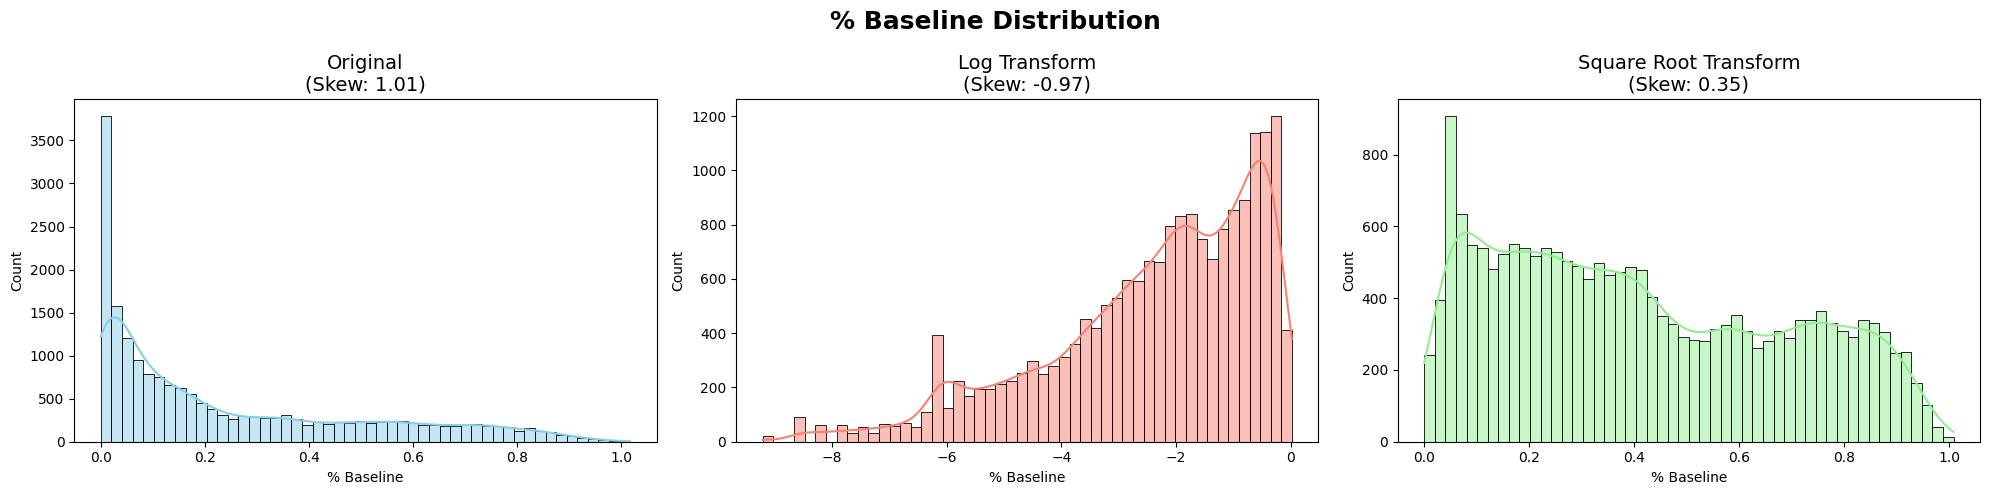

In [12]:
check_transformations(y)

Akan dilakukan square root transform

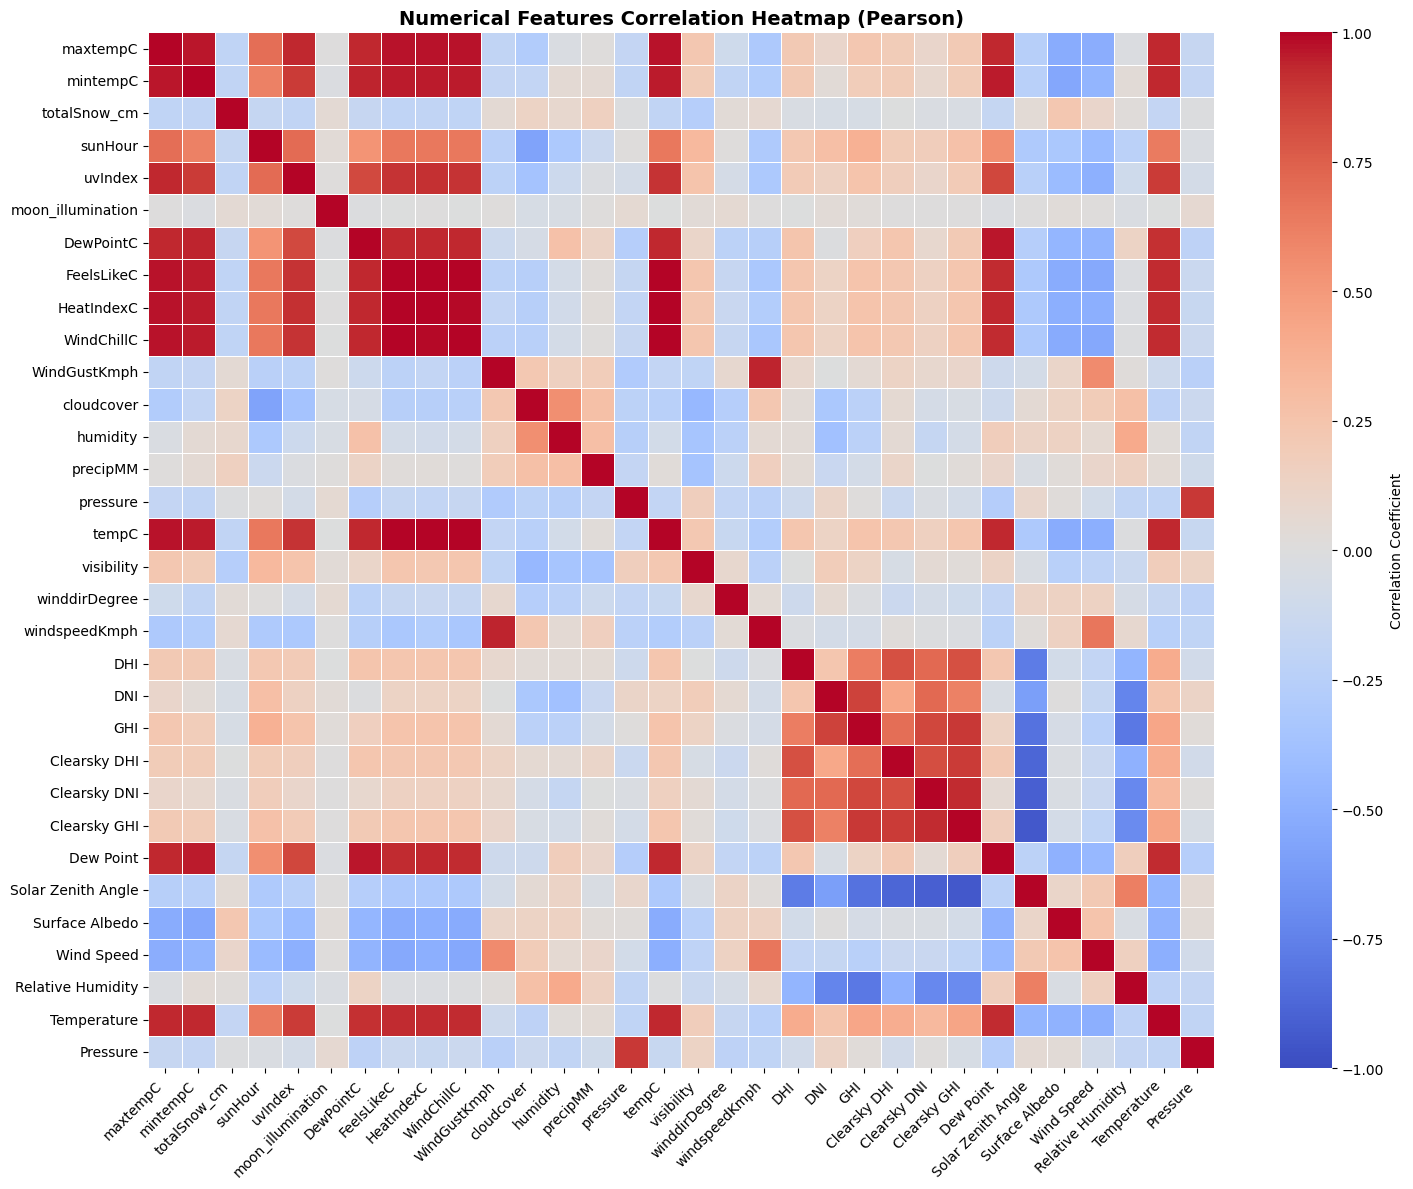

In [13]:
numerical_features = X.select_dtypes(np.number).columns

plot_numerical_correlation(X, numerical_features)

Ada beberapa fitur yang berulang seperti `Temperature` dan `tempC` juga antara `DewPointC` dan `Dew Point`. Mengenai eliminasi fitur fitur tersebut akan dipertimbangkan nantinya 

## Exploration with similar features

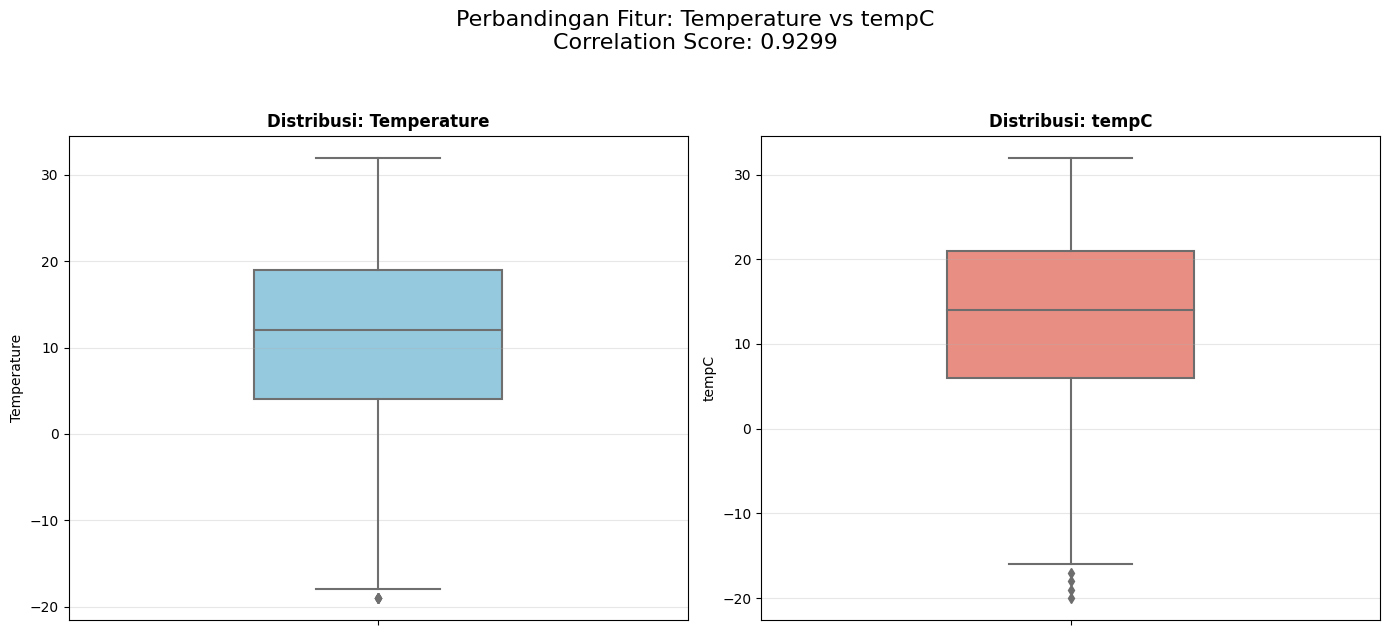

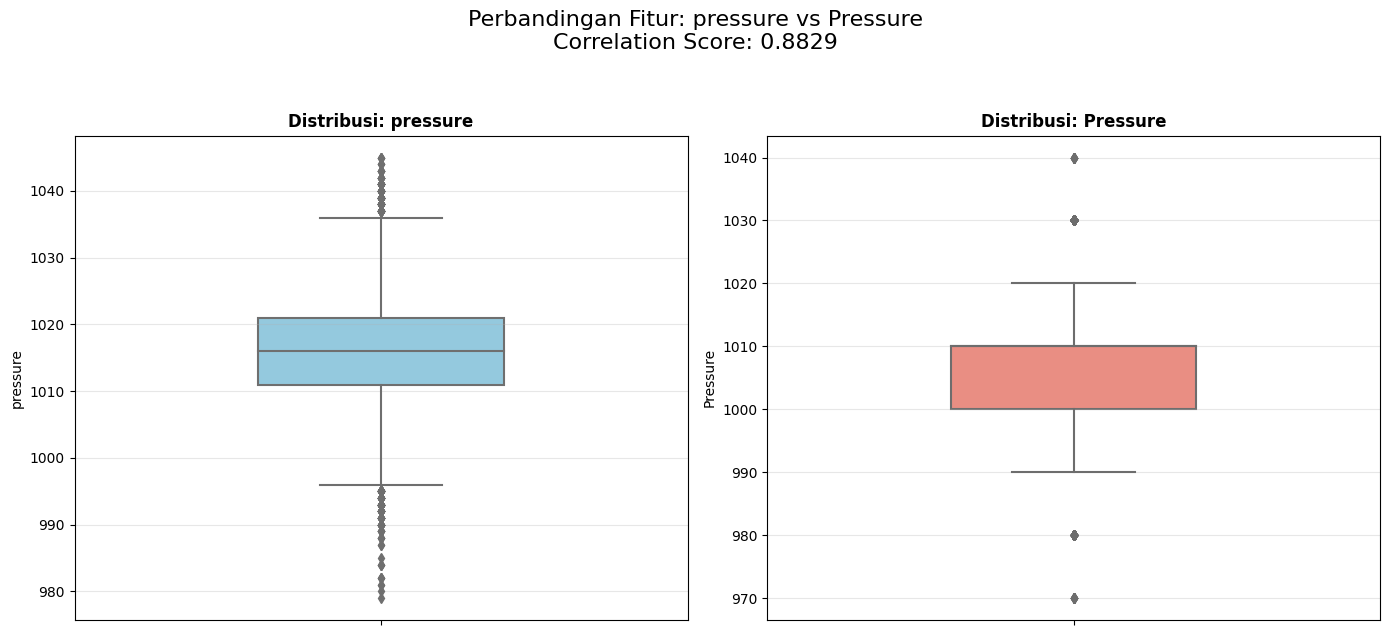

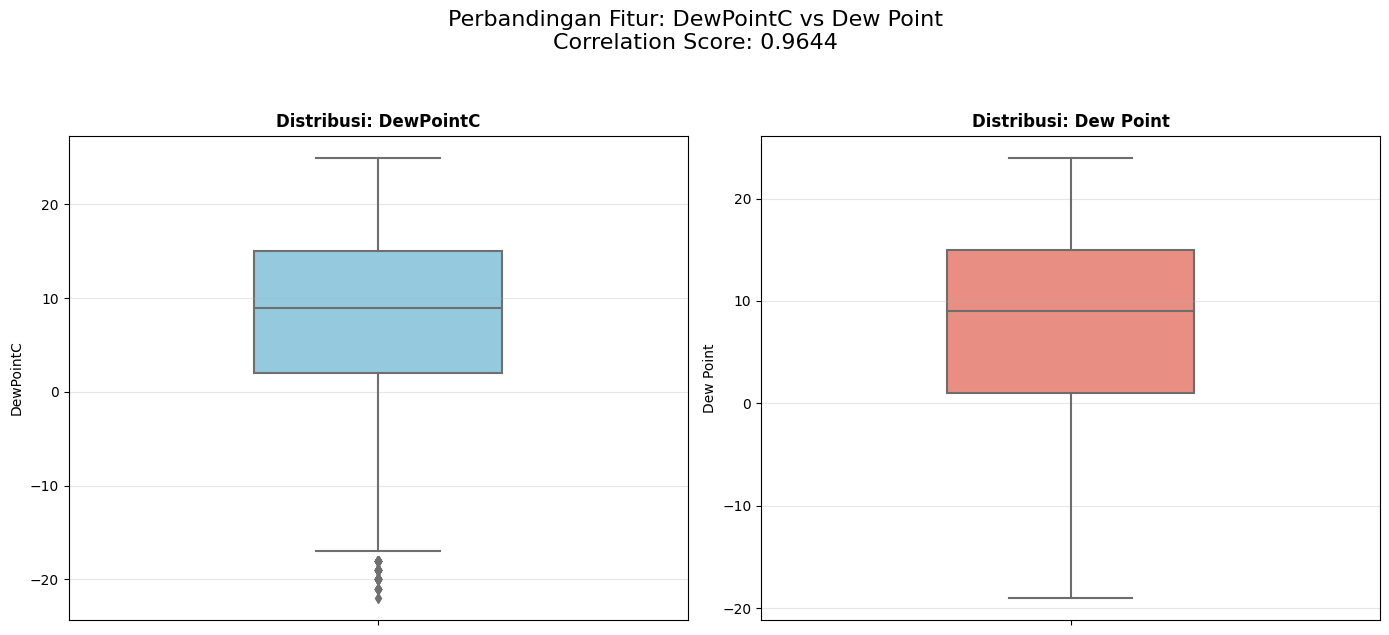

In [33]:
compare_similar_features(train_df, ['Temperature', 'tempC'])
compare_similar_features(train_df, ['pressure', 'Pressure'])
compare_similar_features(train_df, ['DewPointC', 'Dew Point'])

# Modeling

In [47]:
print('============================ Modeling ============================')
TARGET = 'sqrt % Baseline'

train_df[TARGET] = np.sqrt(train_df['% Baseline'])
drop_features = [TARGET, '% Baseline']

numerical_featueres=(train_df.select_dtypes(np.number)
                    .columns.difference(drop_features))

# Soon splitted into nominal and ordinal of categorical columns
categorical_features=(train_df.select_dtypes(include='object')
                     .columns.difference(drop_features))

selected_features=list(numerical_features)+list(categorical_features)
print(f'Total features selected: {len(selected_features)}')

X=train_df[selected_features]
y=train_df[TARGET]

# Basic Preprocessing
preprocessor=ColumnTransformer(transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), CATEGORICAL_FEATURES),
            ('num', StandardScaler(), NUMERICAL_FEATURES)
])



pipeline=Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(max_depth=10, tree_method='hist'))
])

N_SPLITS=5

print(f'Training on {N_SPLITS} KFold')
results = cross_validate(
    pipeline, X, y, 
    cv=KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

print("-" * 60)
for i in range(N_SPLITS):
    rmse = -results['test_score'][i]
    print(f"  Fold {i+1} -> RMSE: {rmse:.2f}")

# Output the mean scores
print("-" * 60)
print(f"  AVG RMSE : {-results['test_score'].mean():.2f}")
print("-" * 60)

============================ Modeling ============================
Total features selected: 37
Training on 5 KFold


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


------------------------------------------------------------
  Fold 1 -> RMSE: 0.10
  Fold 2 -> RMSE: 0.11
  Fold 3 -> RMSE: 0.11
  Fold 4 -> RMSE: 0.10
  Fold 5 -> RMSE: 0.10
------------------------------------------------------------
  AVG RMSE : 0.10
------------------------------------------------------------


In [45]:
results

{'fit_time': array([36.94136977, 36.61443233, 36.59253049, 36.44384837, 20.16896248]),
 'score_time': array([0.1578784 , 0.28516006, 0.28394365, 0.32293892, 0.16089678]),
 'test_score': array([-0.10917977, -0.10815237, -0.10738777, -0.10613302, -0.10628162])}

In [17]:
test_baseline = pipeline.predict(test_df)**2
submission = test_df
submission['% Baseline'] = test_baseline
submission

,Timestamp,% Baseline,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,...,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Solar Zenith Angle,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure
0,2017-10-01 06:00:00,0.024952,21,9,0.0,11.6,5,71,3:26 PM,1:02 AM,...,0.0,0.0,Probably Clear,8,133.20,0.126,2.7,96.31,9,1020
1,2017-10-01 07:00:00,0.030455,21,9,0.0,11.6,5,71,3:26 PM,1:02 AM,...,0.0,0.0,Probably Clear,8,124.69,0.126,2.7,95.77,9,1020
2,2017-10-01 08:00:00,0.133133,21,9,0.0,11.6,5,71,3:26 PM,1:02 AM,...,0.0,0.0,Probably Clear,8,114.68,0.126,2.8,95.30,9,1020
3,2017-10-01 09:00:00,0.346756,21,9,0.0,11.6,5,71,3:26 PM,1:02 AM,...,0.0,0.0,Probably Clear,8,103.89,0.126,2.8,94.95,9,1020
4,2017-10-01 10:00:00,0.501816,21,9,0.0,11.6,5,71,3:26 PM,1:02 AM,...,0.0,0.0,Probably Clear,8,92.80,0.126,2.8,94.59,9,1020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,2017-12-31 12:00:00,0.355091,-9,-13,0.2,8.7,1,88,3:18 PM,5:13 AM,...,229.0,24.0,Probably Clear,-14,87.99,0.866,5.2,80.91,-12,1010
1073,2017-12-31 13:00:00,0.357534,-9,-13,0.2,8.7,1,88,3:18 PM,5:13 AM,...,658.0,172.0,Probably Clear,-14,79.41,0.866,5.3,78.51,-12,1010
1074,2017-12-31 14:00:00,0.187792,-9,-13,0.2,8.7,1,88,3:18 PM,5:13 AM,...,NaN,NaN,NaN,-15,72.41,0.866,5.2,72.04,-11,1010
1075,2017-12-31 15:00:00,0.037925,-9,-13,0.2,8.7,1,88,3:18 PM,5:13 AM,...,NaN,NaN,Probably Clear,-14,67.54,0.866,5.1,67.14,-10,1010


In [18]:
sample_submission = pd.read_csv(SAMPLE_SUBMISSION)
sample_submission['% Baseline'] = test_baseline
sample_submission.to_csv('submission_skeleton.csv', index=False)

sample_submission.head()

,Timestamp,% Baseline
0,"Oct 1, 2017 6am",0.024952
1,"Oct 1, 2017 7am",0.030455
2,"Oct 1, 2017 8am",0.133133
3,"Oct 1, 2017 9am",0.346756
4,"Oct 1, 2017 10am",0.501816
